In [2]:
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt

In [3]:
psd = xr.load_dataset('../../data/Processed/psd_wave.nc')
psd['qair'] = psd['qair']*1000.

# 77, 69, 83, 78, 87, 72, 71, 68, 67, 73
split1 = [[69, 83, 78, 87, 72, 71, 68, 67, 73], [77], [77]]
split2 = [[77, 83, 78, 87, 72, 71, 68, 67, 73], [69], [69]]
split3 = [[77, 69, 78, 87, 72, 71, 68, 67, 73], [83], [83]]
split4 = [[77, 69, 83, 78, 68, 67, 73], [87, 72, 71], [87, 72, 71]]
split5 = [[77, 69, 83, 78, 87, 72, 71, 67, 73], [68], [68]]
split6 = [[77, 69, 83, 68, 87, 72, 71], [78, 67, 73], [78, 67, 73]]
split_ensem = [split1, split2, split3, split4, split5, split6]

In [4]:
group = [[77],[69],[83],[87, 72, 71],[68],[78, 67, 73]]

In [ ]:
from matplotlib.colors import Normalize

group = [[77],[69],[83],[87, 72, 71],[68],[78, 67, 73]]
colors = ['Grays','Purples','Blues','Greens','Oranges','Reds']

for i,sub in enumerate(group):
    sns.kdeplot(data=psd.where(psd.pcode.isin(sub)), x='qair', y='rh', fill=True, 
                cmap=colors[i], alpha=0.8)

plt.gcf().set_dpi(100)

plt.xlabel('Abs. humidity (g/kg)'); plt.ylabel('Rel. humidity (%)')
plt.tight_layout()
plt.show()

/ext3/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/ext3/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


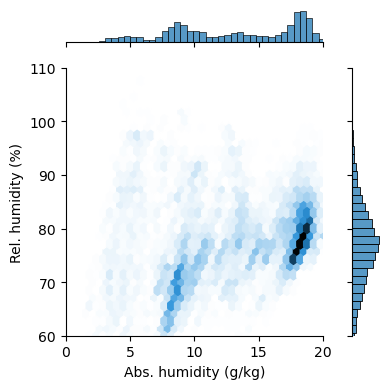

In [43]:
import seaborn as sns

# Custom the inside plot: options are: “scatter” | “reg” | “resid” | “kde” | “hex”
# g = sns.jointplot(x=q[::1], y=rh[::1], kind='kde', xlim=[-5,20],
#               ylim=[40,120], fill=True, height=4)
g = sns.jointplot(x=psd.qair, y=psd.rh, kind='hex', xlim=[0,20],
              ylim=[60,110], height=4, marginal_kws=dict(bins=40, fill=True))
plt.gcf().set_dpi(100)

plt.xlabel('Abs. humidity (g/kg)'); plt.ylabel('Rel. humidity (%)')
plt.tight_layout()
plt.show()

### Split multi-stage campaigns

In [16]:
from tqdm import tqdm

''' Split data based on time interval.
    Interval tolerance in minutes. 2880 = 2 days.
    Note that this doesn't mean the resulting dt are uniform. 
    We've just split really large dt.
'''
def split_psd (psd, pcode, interval_tolerance=2880, latlon_tolerance=1):
    ds = psd.where(psd.pcode==pcode, drop=True) 
    split = []

    for i in tqdm(range(1,len(ds.time)-1)):
        dt_forward = (ds.time[i+1] - ds.time[i]).astype('float32')/6e10
        dt_backward = (ds.time[i] - ds.time[i-1]).astype('float32')/6e10    
        dlat_forward = ds.lat[i+1] - ds.lat[i]  
        dlon_forward = ds.lon[i+1] - ds.lon[i]

        if (dt_forward > interval_tolerance) & (dt_backward > 0): # Split stage that are seperated by more than 2 days
            split.append(i)
        elif (abs(dlat_forward) > latlon_tolerance): 
            split.append(i)
        elif (abs(dlon_forward) > latlon_tolerance): 
            split.append(i)
            
    return ds, split


''' Add a stage label to data set. '''
def stage_label(ds, split):
    stage = np.ones(ds.sizes['time'])
    print(len(split))
    
    for i in range(len(split)):
        if i == 0:
            stage[:(split[i]+1)] *= 0
        else:
            stage[(split[i-1]+1):(split[i]+1)] *= i   
    stage[(split[-1]+1):] *= len(split)
    
    ds['stage'] = ('time', stage)
    
    return ds

100%|██████████| 189/189 [00:00<00:00, 194.25it/s]


8
Lat [-53 -44]
Lon [142 151]


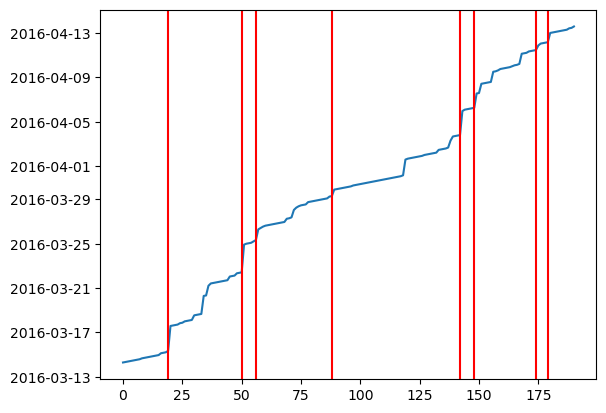

In [74]:
# Manually split and check each one
# Metz=77 Epic=69 WHOTS=87 STRATUS=83 NEAQS=78 HiWInGS=72 GasEx=71 DYNAMO=68 Calwater=67 Capricorn=73

pcode = 73

# We can use a small interval tolerance (say 1 day = 1440 mins) and then further filter based on duration
# Or we can use a larger interval
ds, split = split_psd (psd, pcode, interval_tolerance=2880, latlon_tolerance=1)
if len(split) > 0:
    ds = stage_label(ds, split)
else:
    ds['stage'] = ds['U'] * 0

print('Lat [%.0f %.0f]' %(ds.lat.min(),ds.lat.max()))
print('Lon [%.0f %.0f]' %(ds.lon.min(),ds.lon.max()))
plt.plot(ds.time)
for index in split:
    plt.axvline(index, c='red')

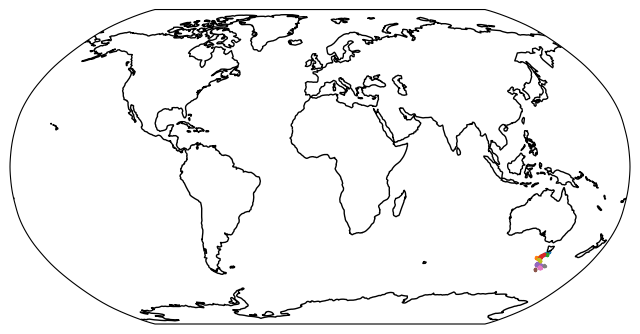

In [75]:
import cartopy.crs as ccrs
from matplotlib import cm

fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson())

ax.set_global()
ax.coastlines()
colors = cm.tab10(np.linspace(0, 1, 10))

U_ = ds.U.values[~np.isnan(ds.U.values)]
U_.max()

# for i, p in enumerate(np.unique(ds.pcode.dropna(dim='time'))):
#     idx = ds.pcode == p
#     pcode = pcodes[str(int(p))]
#     cs = ax.scatter(ds.lon[idx], ds.lat[idx],
#                     s=2, color=plt.get_cmap('Reds')(ds.U[idx]/U_.max()), transform=ccrs.PlateCarree())

for i in range(0, len(split)+1):
    cs = ax.scatter(ds.lon.where(ds.stage==i), ds.lat.where(ds.stage==i),
                    s=2, transform=ccrs.PlateCarree())


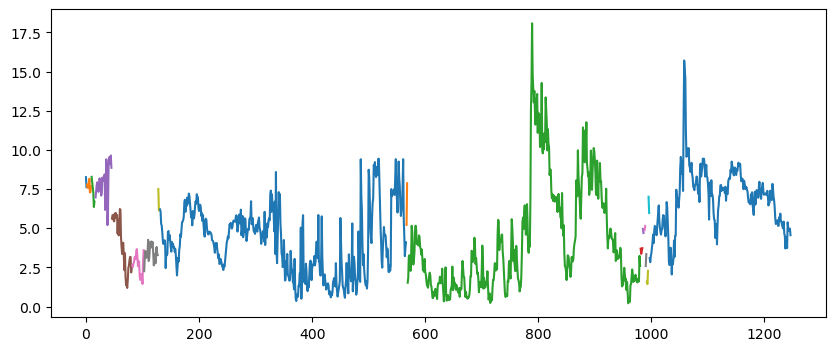

In [69]:
plt.figure(figsize=[10,4])
for i in range(0,len(split)+1):
    plt.plot(ds.U.where(ds.stage==i))

3.96666666707309e-05 2.3333333321791847e-06
0.025747160000000234 0.2922798800000004
0.02879900000000646 0.0089359999999985
0.020181800000000295 0.09658420000000092
0.051730428571429024 0.30598690476190477
nan nan
0.08415300000000059 0.15151766666666688
0.020111999999997465 0.004657999999999163
0.00018399999999729744 0.0003589999999960014
0.005720333333329108 0.4499700000000004
0.0910244444444446 0.21491755555555633
0.10067539999999867 0.24500699999999967
0.008318393939393934 0.01594830303030303
nan nan
0.06603957142857146 0.058339214285714903
0.033452909090908894 0.03332286363636363
0.024247038461538476 0.03565644230769271


(-1.0, 1.0)

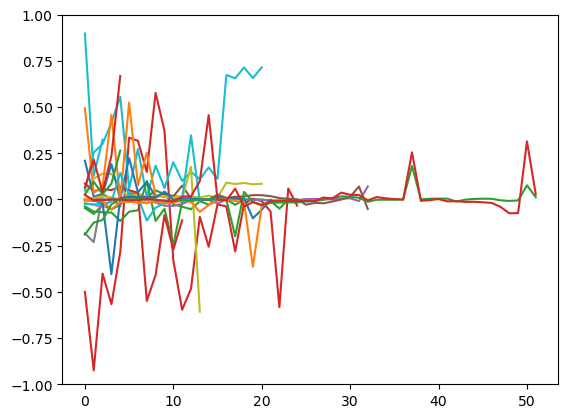

In [63]:
def lon_lat_check (ds, thres=1):
    problematic_i = []
    for i in range(0,len(split)+1):
        lat_diff = ds.lat.where(ds.stage==i, drop=True).diff('time')
        lon_diff = ds.lon.where(ds.stage==i, drop=True).diff('time')
        plt.plot(lat_diff)
        plt.plot(lon_diff)
        print(abs(lat_diff).mean().values,abs(lon_diff).mean().values)
        if (abs(lat_diff.values) > thres).any():
            if (abs(abs(lat_diff.values) - 360) > thres).any():
                print('Stage %d has large latitude movement!' %i)  
                problematic_i.append(i)
        if (abs(lon_diff.values) > thres).any():
            if (abs(abs(lon_diff.values) - 360) > thres).any(): 
                print('Stage %d has large longitude movement!' %i)
                problematic_i.append(i)
        if np.isnan(lat_diff).any() or np.isnan(lon_diff).any():
            print('Stage %d has NaNs!' %i)
            problematic_i.append(i)

lon_lat_check(ds,thres=2)

plt.ylim([-1,1])
# TODO: fix 360

/ext3/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/ext3/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/ext3/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/ext3/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN befo

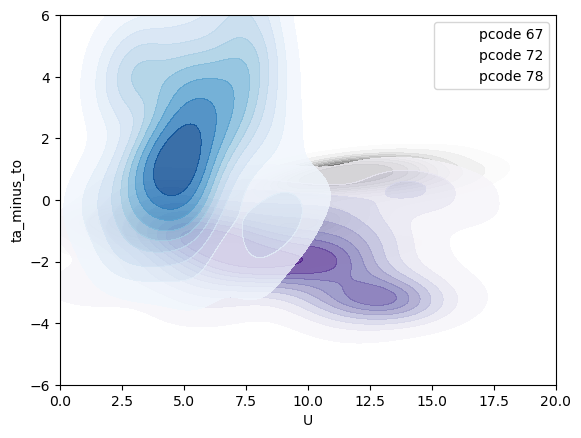

In [90]:
from matplotlib.colors import Normalize

SO = [[71],[73]]
TROPICAL = [[68],[69],[83],[87]]
MID_HIGH_LAT = [[67],[72],[78]]

# group = [[77],[69],[83],[87, 72, 71],[68],[78, 67, 73]]
colors = ['Grays','Purples','Blues','Greens','Oranges','Reds']

for i,sub in enumerate(MID_HIGH_LAT):
    sns.kdeplot(data=psd.where(psd.pcode.isin(sub)), x='U', y='ta_minus_to', fill=True, 
                cmap=colors[i], alpha=0.8, label='pcode %d' %sub[0])

plt.gcf().set_dpi(100)

# plt.xlabel('Abs. humidity (g/kg)'); plt.ylabel('Rel. humidity (%)')
# plt.tight_layout()
# plt.show()
plt.xlim(0,20); plt.ylim([-6,6])
plt.legend()

In [79]:
psd['ta_minus_to'] = ('time', psd.tair.values-psd.tsea.values)